In [1]:
from scipy import stats, special, math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pymc3 as pm
import arviz as az
import pandas as pd
from theano import shared
from theano import tensor as T
import seaborn as sns
from scipy.special import expit as logistic
import statsmodels as sm
from statsmodels.graphics import tsaplots as smplots
import warnings
import theano
import theano.tensor as tt
from scipy.special import expit as logistic
import seaborn as sns

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import statsmodels as stm

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
prison = pd.read_csv('/home/mach1ne/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [3]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')
# Filter first 12 series
y = prison_pivot.loc[:,['NSW', 'WA', 'SA']]

In [5]:
y

state           NSW                                    WA                     \
gender       Female               Male             Female               Male   
legal      Remanded Sentenced Remanded Sentenced Remanded Sentenced Remanded   
t                                                                              
2005-03-01      182       468     1972      6396       61       210      495   
2005-06-01      191       461     1975      6472       52       216      518   
2005-09-01      186       437     1844      6540       49       201      504   
2005-12-01      172       457     1860      6502       43       193      488   
2006-03-01      191       452     1967      6493       53       194      530   
2006-06-01      194       463     2005      6594       53       195      544   
2006-09-01      202       484     2031      6571       57       201      543   
2006-12-01      218       476     2074      6661       68       213      565   
2007-03-01      217       463     2154      6664       72       217      598   
2007-06-01      209       488     2173      6761       76       243      604   
2007-09-01      211       470     2167      6746       61       261      640   
2007-12-01      199       467     2272      6622       54       264      622   
2008-03-01      199       443     2354      6606       64       233      658   
2008-06-01      208       485     2363      6703       56       202      701   
2008-09-01      201       514     2322      6903       74       207      716   
2008-12-01      208       524     2324      6875       84       222      654   
2009-03-01      234       511     2491      6855       74       229      614   
2009-06-01      236       531     2477      7142       67       256      678   
2009-09-01      222       546     2484      7147       71       290      639   
2009-12-01      207       562     2389      7190       59       321      668   
2010-03-01      217       540     2519      7006       65       323      670   
2010-06-01      217       558     2561      7091       75       328      753   
2010-09-01      193       555     2398      7090       69       335      696   
2010-12-01      193       545     2330      7032       63       316      689   
2011-03-01      192       501     2564      6749       63       307      763   
2011-06-01      201       488     2665      6763       64       297      797   
2011-09-01      201       487     2569      6707       59       284      782   
2011-12-01      193       455     2511      6648       82       283      814   
2012-03-01      208       438     2523      6549       93       296      871   
2012-06-01      204       436     2454      6628       95       325      888   
2012-09-01      216       439     2371      6613       97       335      881   
2012-12-01      214       439     2498      6569       98       342      873   
2013-03-01      231       449     2635      6544      109       348      907   
2013-06-01      227       467     2694      6642      105       343      955   
2013-09-01      232       460     2620      6757      100       349      874   
2013-12-01      239       460     2656      6925       93       357      882   
2014-03-01      262       477     2901      6940      108       362      911   
2014-06-01      267       498     2936      7205      123       353     1012   
2014-09-01      221       502     2594      7254      135       351     1043   
2014-12-01      223       497     2639      7231      147       370     1065   
2015-03-01      298       493     3124      7190      156       376     1073   
2015-06-01      303       543     3278      7493      147       380     1135   
2015-09-01      305       575     3431      7595      141       373     1191   
2015-12-01      305       570     3490      7815      160       357     1314   
2016-03-01      349       552     3749      7742      171       367     1425   
2016-06-01      414       526     3850      7853      206       401     1566   


In [7]:
state_idx = pd.get_dummies(
        [i[0] for i in y]
    ).values.argmax(1)

gender_idx = pd.get_dummies(
        [i[1] for i in y]
    ).values.argmax(1)

legal_idx = pd.get_dummies(
        [i[2] for i in y]
    ).values.argmax(1)

In [8]:
state = np.unique(state_idx).shape[0]
gender = np.unique(gender_idx).shape[0]
legal = np.unique(legal_idx).shape[0]

In [9]:
n_series = y.columns.unique().shape[0]
y = y.values
X = np.arange(y.shape[0]).reshape(y.shape[0], 1)

In [ ]:
plt.scatter(X, y[:,0]);

# 1. Gaussian Process Regression

## 1.1 Model Definition


$$
\begin{align*}
y_t &= a + a_{cov1}X1 + a_{cov2}X2 + a_{cov3}X3 + b \;t + \gamma_t + \epsilon_t,  & \epsilon_t \sim NID(0, \sigma^2_\epsilon) \\
\epsilon_{t+1} &= \phi \epsilon_t + \eta_t, & \eta_t \sim NID(0, \sigma^2_\eta) \\
\gamma_{1,t+1} &= -\gamma_{1,t} - \gamma_{2,t} - ... - \gamma_{12,t} \\
\gamma_{2,t+1} &= \gamma_{1,t} \\
\gamma_{3,t+1} &= \gamma_{2,t} \\
[...]
\end{align*}
$$

where $a$ represents the deterministic level, $b$ the deterministic trend, $t$ denotes time, $\epsilon$ refer to the observation disturbance, $\gamma$ to the deterministic seasonal component of the series, $a_{cov}$ are the group effects, $\phi$ is the autoregressive coefficient and $\eta$ are the residuals.

The first equation is called the observation or measurement equation.


### 1.1.1 Model structure

1. Hyperprior level 0: All
2. Hyperprior level 1: state, gender, legal
3. Adaptative priors
4. Latent process
5. Likelihood

### 1.1.2 Modeling groups


state -> s, gender -> g, legal -> l

$$\begin{aligned}
Y_{t,i} = \beta_0&  & \textrm{baseline} \\ 
&+\sum_s{\beta_{1,s} x_{1,s}} + \sum_g{\beta_{2,g} x_{2,g}} + \sum_l{\beta_{3,l} x_{3,l}} & \textrm{group effects}\\ &+\beta_{4} * Y_{t-1} & \textrm{AR effect - covariate} \\
&+ \epsilon & \textrm{error term} \end{aligned}$$


#### 1.1.2.1 Define constraints to the deflections (effects):

We want the predicted value to be a baseline plus a deflection due to the level of factor 1 plus a deflection due to the level of factor 2, etc.

$$\sum_s\beta_{1,s} = 0$$
$$\sum_g\beta_{2,g} = 0$$
$$\sum_l\beta_{3,l} = 0$$

So,

$$\begin{aligned}
&\beta_0 +\sum_s{\beta_{1,s} x_{1,s}} + \sum_g{\beta_{2,g} x_{2,g}} + \sum_l{\beta_{3,l} x_{3,l}} +\beta_{4} * x_{cov} \\
&= \alpha_0 + \bar \alpha - \alpha_{cov} \bar x_{cov} + \sum_s{(\alpha_s - \bar \alpha)x_s} + \sum_g{(\alpha_g - \bar \alpha)x_g} + \sum_l{(\alpha_l - \bar \alpha)x_l} + \alpha_{cov} x_{cov}
\end{aligned}$$

where $\bar \alpha = \frac{1}{S} \sum^{S}_{s=1} \alpha_s + \frac{1}{G} \sum^{G}_{g=1} \alpha_g + \frac{1}{L} \sum^{L}_{l=1}\alpha_{l}$

In our case $x_{cov} = y_{t-1}$, since we are defining an autoregressive process.

Describe the method that uses the cell structure to derive the coefficients (overall mean, marginal means, etc).
$$\begin{aligned}
\beta_0 &= \alpha_0 +  \bar \alpha - \alpha_{cov} \bar x_{cov} \\
\beta_1 &= \frac{1}{S} \sum_s (\alpha_s - \bar \alpha) \\
\beta_2 &= \frac{1}{G} \sum_g (\alpha_g - \bar \alpha) \\
\beta_3 &= \frac{1}{L} \sum_l (\alpha_l - \bar \alpha) \\
\beta_{cov} &= \alpha_{cov}
\end{aligned}$$

Do the same for interactions.


### 1.1.2 Notation for complete Bayesian model

Here I'll include the hierarchical structure of the model, not only the likelihood equations.



## 1.2 Single series prediction using Gaussian Processes

In [12]:
with pm.Model() as model:
    ℓ = pm.Gamma('ℓ', alpha = 2, beta=1)
    η = pm.HalfCauchy('η', beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func = cov)
    
    σ = pm.HalfCauchy('σ', beta=5)
    y_ = gp.marginal_likelihood('y', X=X, y=y[:,0], noise=σ)
    
    mp = pm.find_MAP()

In [14]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"],
              "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])],})

,Parameter,Value at MAP
0,ℓ,5.118972
1,η,164.938933
2,σ,6.855829


### Using `.conditional`

In [26]:
# new values from x=0 to x=60
X_new = np.linspace(0, 60, 600)[:,None]

# Add the GP conditional to the model, given the new X values
with model:
    f_pred_1 = gp.conditional('f_pred_1', X_new)

In [27]:
# To use the MAP values replace the trace with a length-1 list with mp
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred_1], samples=2000)

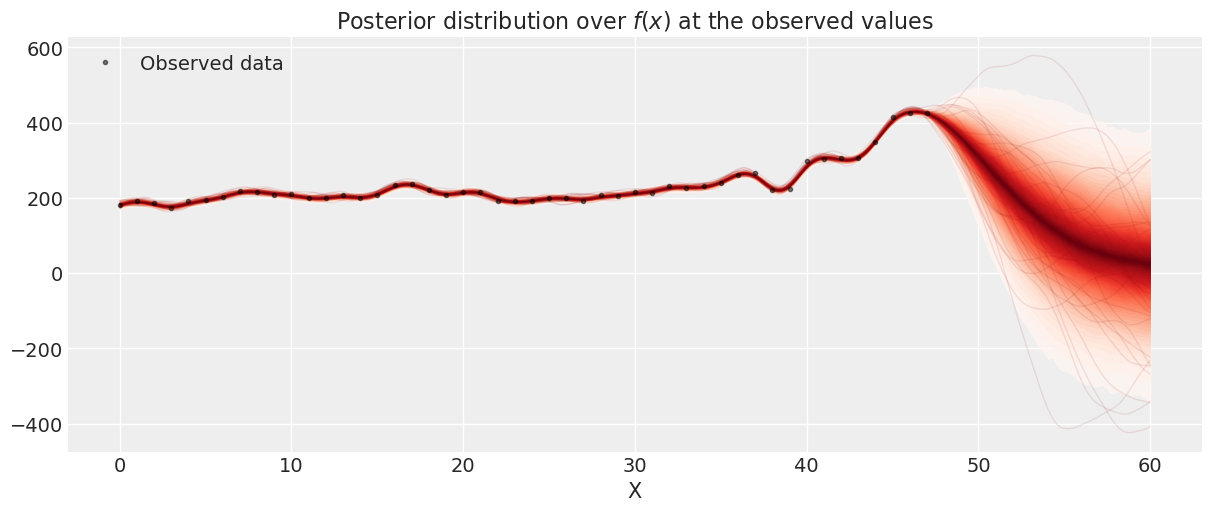

In [30]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred_1"], X_new);

# plot the data
plt.plot(X, y[:,0], 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

#### Adding noise

In [28]:
with model:
    y_pred_1 = gp.conditional("y_pred_1", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive([mp], vars=[y_pred_1], samples=2000)

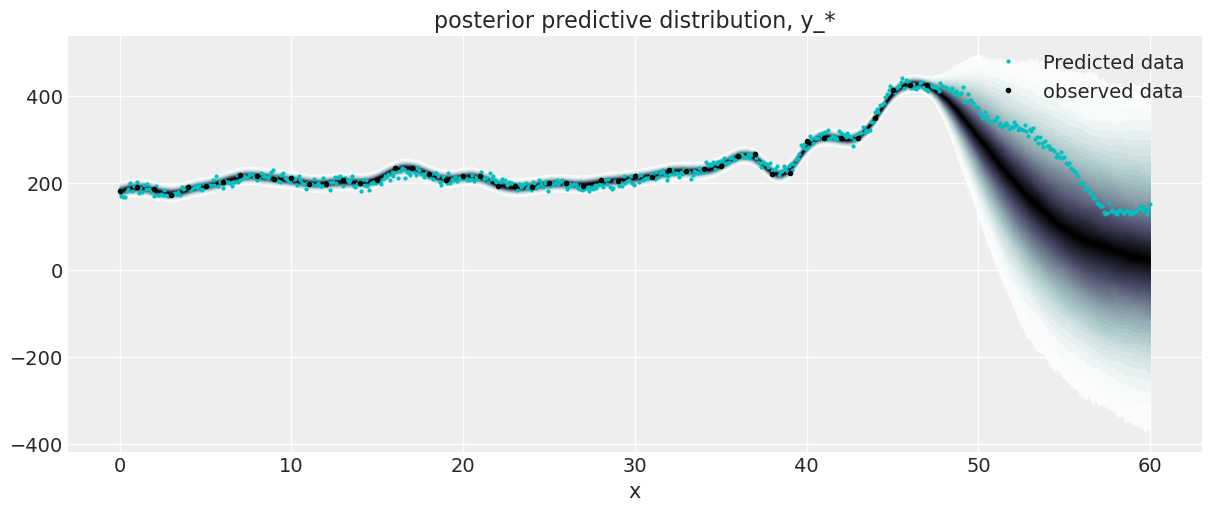

In [34]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred_1"], X_new, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(X_new, y_samples["y_pred_1"][800, :].T, "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(X, y[:,0], 'ok', ms=3, alpha=1.0, label="observed data");

plt.xlabel("x");
plt.title("posterior predictive distribution, y_*"); plt.legend();

Notice that the posterior predictive density is wider than the conditional distribution of the noiseless function, and reflects the predictive distribution of the noisy data, which is marked as black dots. The light colored dots don’t follow the spread of the predictive density exactly because they are a single draw from the posterior of the GP plus noise.

## 1.3 Adding groups

In [ ]:
y_ = shared(y)
with pm.Model() as model:
    b = pm.Normal("b",80, 5)

    # Regularizing prior for phi
    phi = pm.Bound(pm.Laplace, lower = -1, upper=1)("phi", 0.0, 0.05)
    tau = pm.HalfNormal("tau", 1)
    
    alpha_pre = pm.Normal('alpha_pre', 0, 25, shape=(4,1))
    alpha = pm.Deterministic('alpha', alpha_pre - tt.mean(alpha_pre,axis=0))
    seasonality = alpha[np.arange(y.shape[0])%4]
    
    a0 = pm.Normal('a0', mu=y[0,:].mean(), sd=50)      
    a1 = pm.Normal('a1', mu=0.0, sd=100, shape=state)
    a2 = pm.Normal('a2', mu=0.0, sd=100, shape=gender)
    a3 = pm.Normal('a3', mu=0.0, sd=100, shape=legal)
            
    mu = (a0 + # global level
          a1[state_idx] + a2[gender_idx] + a3[legal_idx] + # group effects
          X * b + # global trend 
          seasonality) # global seasonality

    err = y_- mu
    y_pred = AR("y_pred", k=phi, tau_e=tau, observed=err) # global AR(1)
    trace = pm.sample(draws=2000, 
                      tune=4000, 
                      init="advi+adapt_diag",
                      target_accept=0.90)

pm.plots.traceplot(trace_pool);